In [1]:
import pandas as pd
import numpy as array_lib
import scipy
import plotly.express as px

In [2]:
indir = "/Shares/down/public/INLCUDE_2024/kallisto_20241030/selfannoated/"
rankablefile = indir+"kallisto_200401lines_participants_normcounts.csv"
boolfile = indir+"full_HP_binary_attribute.csv"
geneindir = "/Shares/down/public/INLCUDE_2024/kallisto_20241030/metadata/"
outdir="/Users/allenma/hypergeomad/"
genefile = geneindir+ "gencode.v27.chr_patch_hapl_scaff.annotation.gtf.df"


In [3]:
bool_df = pd.read_csv(boolfile, index_col=0)
rank_df =pd.read_csv(rankablefile, index_col=0)

In [4]:
print(bool_df.columns.to_list())

['HP_Abdominal_pain', 'HP_Abnormal_aortic_valve_morphology', 'HP_Abnormal_cardiovascular_system_physiology', 'HP_Abnormal_cerebral_artery_morphology', 'HP_Abnormal_circulating_metabolite_concentration', 'HP_Abnormal_duodenum_morphology', 'HP_Abnormal_electrophysiology_of_sinoatrial_node_origin', 'HP_Abnormal_esophagus_morphology', 'HP_Abnormal_exteroceptive_sensation', 'HP_Abnormal_eye_morphology', 'HP_Abnormal_foot_morphology', 'HP_Abnormal_hair_morphology', 'HP_Abnormal_heart_morphology', 'HP_Abnormal_heart_valve_morphology', 'HP_Abnormal_hip_bone_morphology', 'HP_Abnormal_intestine_morphology', 'HP_Abnormal_joint_morphology', 'HP_Abnormal_larynx_morphology', 'HP_Abnormal_leukocyte_count', 'HP_Abnormal_leukocyte_morphology', 'HP_Abnormal_liver_physiology', 'HP_Abnormal_metabolism', 'HP_Abnormal_mitral_valve_physiology', 'HP_Abnormal_morphology_of_the_great_vessels', 'HP_Abnormal_oral_cavity_morphology', 'HP_Abnormal_peripheral_nervous_system_morphology', 'HP_Abnormal_preputium_morpho

In [5]:
print(rank_df.columns)

Index(['ENSG00000000003.14', 'ENSG00000000005.5', 'ENSG00000000419.12',
       'ENSG00000000457.13', 'ENSG00000000460.16', 'ENSG00000000938.12',
       'ENSG00000000971.15', 'ENSG00000001036.13', 'ENSG00000001084.10',
       'ENSG00000001167.14',
       ...
       'ENSG00000284740.1', 'ENSG00000284741.1', 'ENSG00000284742.1',
       'ENSG00000284743.1', 'ENSG00000284744.1', 'ENSG00000284745.1',
       'ENSG00000284746.1', 'ENSG00000284747.1', 'ENSG00000284748.1',
       'Participant'],
      dtype='object', length=58289)


In [57]:
def calculateNESpval(actualES, simES,use_gpu):
    '''Calculate NES and p-value'''
    #sys.stdout = open('mylog.log', 'a')
    if actualES > 0:
            print("actualES > 0", actualES)
            simESsubset = array_lib.array([x for x in simES if x > 0])
            mu = array_lib.mean(simESsubset)  # Use array_lib mean
            NES = -(actualES / mu)
            sigma = array_lib.std(simESsubset)  # Use array_lib std
            if use_gpu:
                actualES_np = actualES.get()
                mu_np = mu.get()
                sigma_np = sigma.get()
            else:
                actualES_np = actualES
                mu_np = mu
                sigma_np = sigma
            p = 1 - scipy.stats.norm.cdf(actualES_np, mu_np, sigma_np)
    else:
            simESsubset = array_lib.array([x for x in simES if x < 0])
            mu = array_lib.mean(simESsubset)  # Use array_lib mean
            NES = actualES / mu
            sigma = array_lib.std(simESsubset)  # Use array_lib std
            if use_gpu:
                actualES_np = actualES.get()
                mu_np = mu.get()
                sigma_np = sigma.get()
            else:
                actualES_np = actualES
                mu_np = mu
                sigma_np = sigma
            p = scipy.stats.norm.cdf(actualES_np, mu_np, sigma_np)
    return NES, p


def run_a_ba(ba,valuecols, outdir, commoncolumn, rankorderdf, badf, keepsamples,use_gpu):
    bacols_common = [ba, commoncolumn]
    valuecols_common = valuecols+[commoncolumn]
    subbadf = badf[bacols_common]
    subrankorderdf = rankorderdf[valuecols_common]
    mergedf = subbadf.merge(subrankorderdf, on=commoncolumn, how="inner")
    if len(keepsamples)>1:
        mergedf = mergedf[mergedf[commoncolumn].isin(keepsamples)]
    df = mergedf.sample(frac=1).reset_index(drop=True) #Randomizes the order of the merged datafame before we sort on rank value so 0 are in diff order each time
    thiscomorbidity_binary = df[ba].to_list()
    simES_norm = permute_area_norm(thiscomorbidity_binary, permutations=1000)
    lines = []
    collectgraphinfo = []
    for colname in valuecols:
        df = df.sort_values(colname)
        fig_df2 = df.copy()
        fig_df2["rank"] = array_lib.arange(len(df))
        #bins_n = 10
        bins_n = 5
        fig_df2["rankbins"] = pd.qcut(fig_df2["rank"], bins_n)
        percent_ba_bins = fig_df2.groupby("rankbins")[ba].sum()/fig_df2.groupby("rankbins")[ba].count()
        percent_ba_bins = pd.DataFrame(percent_ba_bins)
        percent_ba_bins["percent_sample"] = [int(p) for p in range(100 // bins_n, 101, 100 // bins_n)]
        percent_ba_bins["n_sample"] = percent_ba_bins["percent_sample"]*(fig_df2.shape[0]/100)
        percent_ba_bins["n_sample"] = percent_ba_bins["n_sample"].astype(int)
        fig = px.bar(percent_ba_bins,x="n_sample", y=ba, labels={"n_sample": "Samples rank "+colname+" lowest to highest in bins", ba:"Percent "+ba}, template="plotly_white", range_y=[0, 0.6])
        #fig = px.bar(percent_ba_bins,x="n_sample", y=ba, labels={"n_sample": "Samples rank "+colname+" lowest to highest in bins", ba:"Percent "+ba}, template="plotly_white")
        fig.show()
        fig_df2 = fig_df2[fig_df2[ba]==1]
        fig_df2["size"] = fig_df2[ba]/100
        fig = px.density_heatmap(fig_df2,x="rank", y=ba, labels={"rank": "Sample rank "+colname+" lowest to highest", ba:"Number with "+ba},nbinsx=10)
        fig.show()
        thiscomorbidity_binary = df[ba].to_list()
        actualES_norm, normalized_pc_score_norm, thistrend_norm, thiscumscore_norm = area_score_norm(thiscomorbidity_binary)
        # Column-bind (each array as a column)
        stacked = array_lib.column_stack([thistrend_norm, thiscumscore_norm])
        columns = ['trend', 'cumscore']
        fig_df = pd.DataFrame(stacked, columns=columns)
        fig_df['rank'] = array_lib.arange(len(df))
        df_long = fig_df.melt(id_vars=['rank'], 
                  value_vars=['trend', 'cumscore'], 
                  var_name='measurement', value_name='value')
        fig = px.scatter(df_long, x="rank", y="value", color="measurement", labels={"rank": "Sample rank "+colname+" lowest to highest", "value":"Enrichment of "+ba}, template="plotly_white")
        fig.show()
        onegeneNES, onegenepval = calculateNESpval(actualES_norm, simES_norm,use_gpu)
        line = [colname, onegeneNES, onegenepval]
        lines.append(line)
        collectgraphinfo.append([colname, percent_ba_bins, fig_df])
    baNESpvals = pd.DataFrame(lines, columns = ["ranked_by","NES", "pval"])
    baNESpvals["boolean_attribute"]=ba
    baNESpvals = baNESpvals[["boolean_attribute", "ranked_by","NES", "pval"]]
    return baNESpvals, collectgraphinfo

def permute_area_norm(ar_ticks, permutations=1000, seed=42):
    '''Generates permutations of the ranks and calculates AUC for each
        permutation.'''

    array_lib.random.seed(seed=seed)
    ar_ticks = array_lib.array(ar_ticks)
    es_permute = []
    for i in range(permutations):
        random_ar_score = array_lib.random.permutation(ar_ticks)  # Array_lib permutation
        es_permute_score = area_score_norm(random_ar_score)  # Use area_score_norm
        es_permute.append(es_permute_score[0])

    return es_permute

def area_score_norm(ar_ticks, verbose=False):
    '''Calculate the GSEA like enrichment score using the comorbidity
    occurance in the rank as our set'''
    #sys.stdout = open('mylog.log', 'a')
    ar_score = array_lib.array([1 if i > 0 else 0 for i in ar_ticks])  # Use array_lib (either cp or array_lib)
    total = float(array_lib.sum(ar_score))  # Use array_lib sum

    binwidth = 1.0 / float(len(ar_score))
    normalized_ar_score = array_lib.multiply(array_lib.divide(ar_score, total), binwidth)  # Normalization with array_lib

    cumscore = array_lib.cumsum(normalized_ar_score)  # Cumulative sum with array_lib
    trend = array_lib.append(array_lib.arange(0, 1, 1.0 / float(len(cumscore) - 1)), 1.0)
    trend = array_lib.multiply(trend, binwidth)  # Multiplying trend by binwidth

    actual_es = (array_lib.trapz(cumscore) - array_lib.trapz(trend)) *2

    if verbose:
        print("Binwidth                        :"+str(binwidth))
        print("Sum of normalized binary scores :"+str(array_lib.sum(normalized_ar_score)))
        print("Sum cumulative score            :"+str(array_lib.sum(cumscore)))
        print("Sum of trend                    :"+str(array_lib.sum(trend)))
        print("Len of trend                    :"+str(len(trend)))
        print("Actual Area                     :"+str(actual_es))

    return [actual_es, normalized_ar_score, trend, cumscore]

In [58]:
#ba="HP_Hypothyroidism"
#ba="HP_Obstructive_sleep_apnea"
ba="HP_Abnormality_of_the_skeletal_system"
#ba="HP_Obstructive_sleep_apnea"
badf = bool_df[["Participant", "HP_Abnormality_of_the_skeletal_system", "HP_Abnormal_heart_morphology", "HP_Obstructive_sleep_apnea"]]
rankorderdf = rank_df[["Participant", "ENSG00000160310.17", "ENSG00000159200.17"]]
use_gpu = False
keepsamples = rankorderdf["Participant"].to_list()
commoncolumn = "Participant"
valuecols = [cn for cn in rankorderdf if cn!=commoncolumn]

/tmp/ipykernel_507224/3709988792.py:56: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



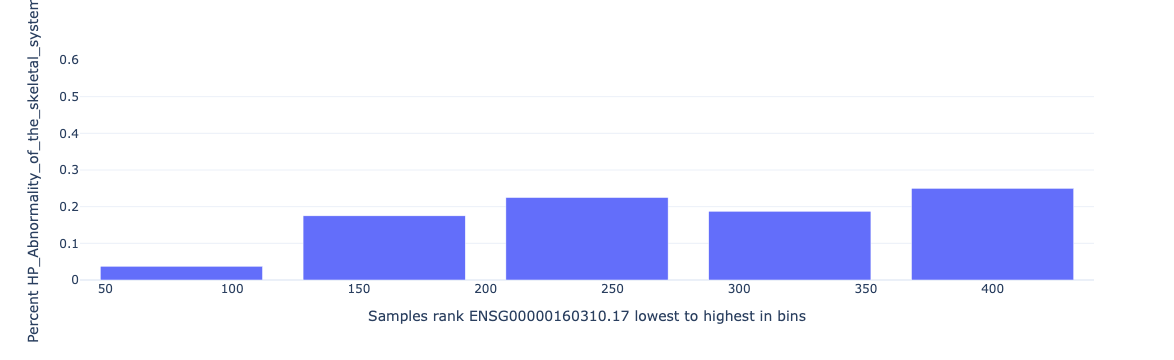

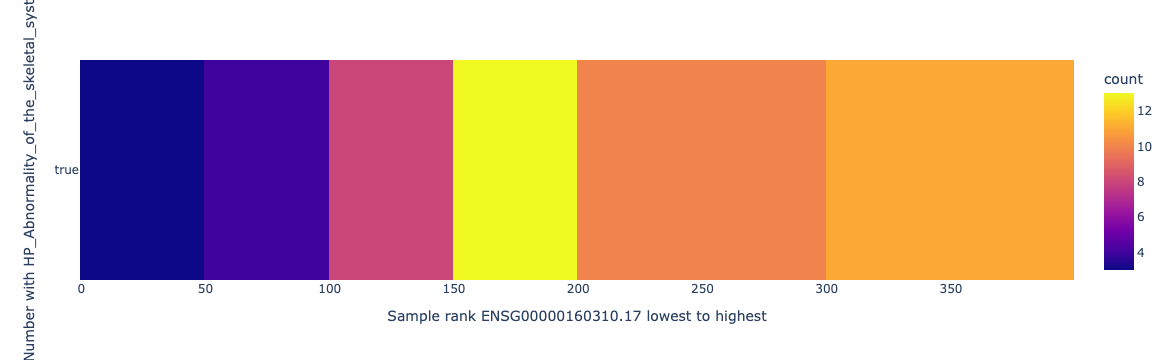

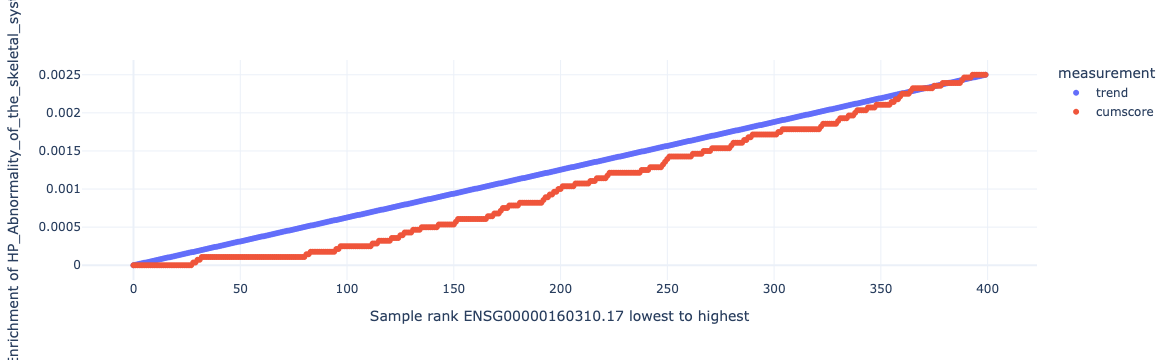

/tmp/ipykernel_507224/3709988792.py:56: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



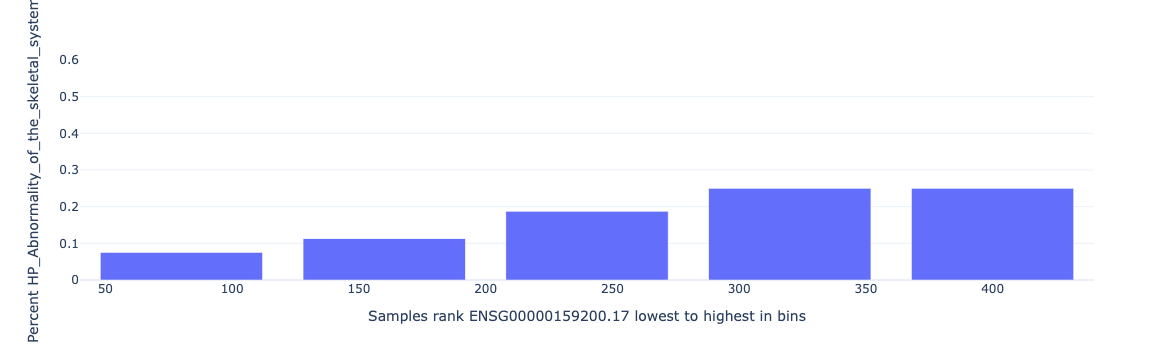

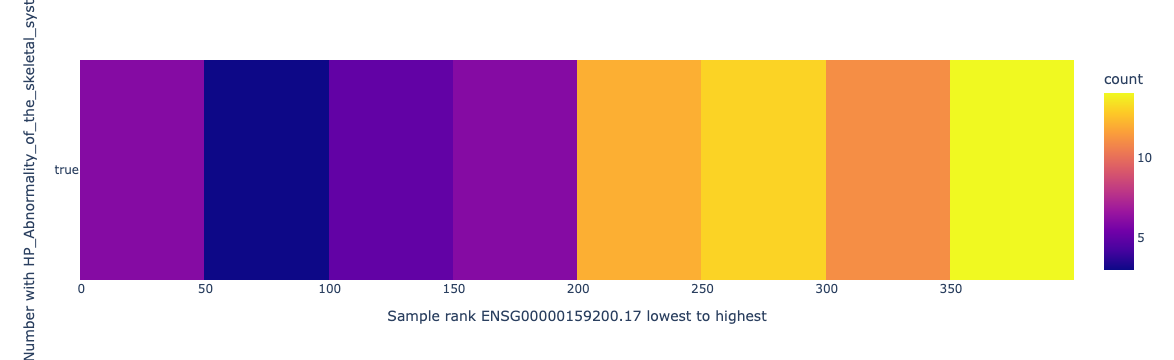

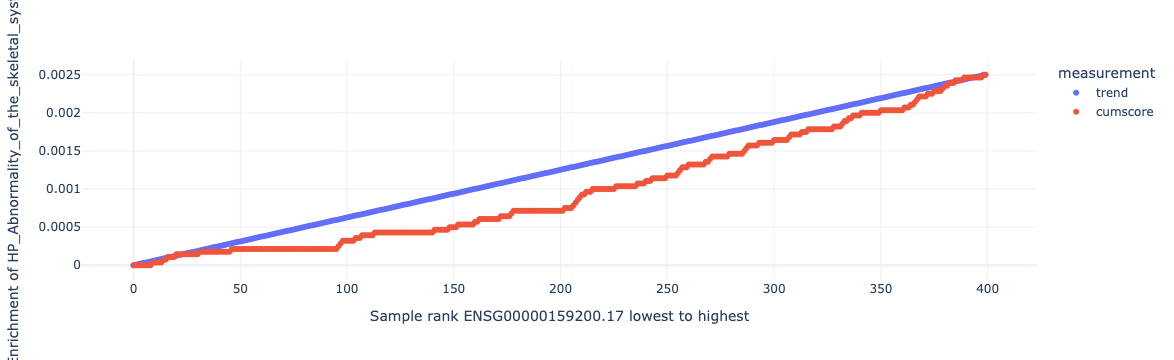

In [59]:
baNESpvals, collectgraphinfo= run_a_ba(ba,valuecols, outdir, commoncolumn, rankorderdf, badf, keepsamples,use_gpu)

In [47]:
baNESpvals

,boolean_attribute,ranked_by,NES,pval
0,HP_Abnormality_of_the_skeletal_system,ENSG00000160310.17,3.588669,0.000397
1,HP_Abnormality_of_the_skeletal_system,ENSG00000159200.17,4.323047,0.000008


In [48]:
#boolean_attribute 	ranked_by 	NES 	pval
#0 	HP_Abnormality_of_the_skeletal_system 	ENSG00000160310.17 	3.588669 	0.000397
#1 	HP_Abnormality_of_the_skeletal_system 	ENSG00000159200.17 	4.323047 	0.000008#

In [49]:
# 	boolean_attribute 	ranked_by 	NES 	pval
#0 	HP_Obstructive_sleep_apnea 	ENSG00000160310.17 	5.996683 	4.211710e-11
#1 	HP_Obstructive_sleep_apnea 	ENSG00000159200.17 	8.124849 	1.039146e-2